In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'
import dask.dataframe as dd
from scipy.stats import norm

from sklearn.cluster import KMeans
import numpy as np

import pandas



/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_57759/1208524283.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
#load mobility and temperature data
#load heatwave - control dataframe
mobility_heat = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/united_states/THI_mobility_heat_clean_90.csv')
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/united_states/THI_heatwave_control_90.csv')

## Build Intensity Variable


In [3]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/united_states/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df = full_df[~full_df['month'].isin([4, 10])]
full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


In [4]:
mobility_heat['control_day'] = pd.to_datetime(mobility_heat['control_day'])

In [5]:
#merge temperatures from control day onto mobility heat
mobility_heat = mobility_heat.merge(full_df[['datetime', 'thi', 'location']], left_on=['location', 'control_day'], right_on=['location', 'datetime'], suffixes=('_heat', '_control'))

In [6]:
(mobility_heat['thi_heat'] - mobility_heat['thi_control']).max()

19.68433122623494

In [7]:
np.corrcoef(mobility_heat['thi_heat'], mobility_heat['thi_control'])


array([[1.        , 0.70161434],
       [0.70161434, 1.        ]])

### Create/explore temperature difference variable

In [8]:
mobility_heat['thi_diff'] = mobility_heat['thi_heat'] - mobility_heat['thi_control']

In [9]:
mobility_heat['thi_diff'].describe()

count    35127.000000
mean         6.805378
std          3.218647
min          0.867800
25%          4.232981
50%          6.369885
75%          8.976771
max         19.684331
Name: thi_diff, dtype: float64

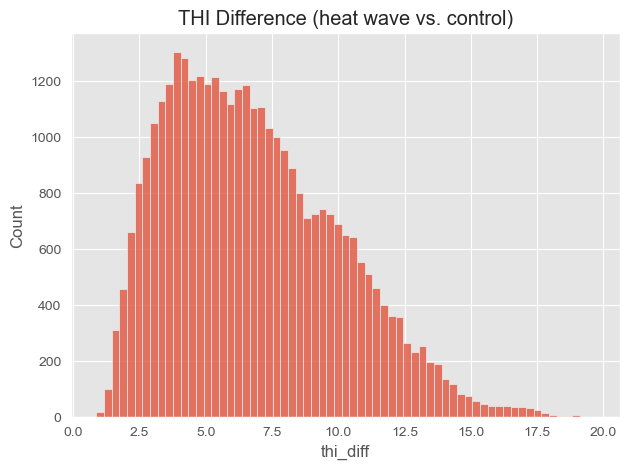

In [10]:
sns.histplot(mobility_heat, x='thi_diff')
plt.title("THI Difference (heat wave vs. control)")
plt.tight_layout()
plt.savefig(data_path + '/img/12_09_2023/india_temp_diff_dist.png')

### Build Duration Variable
* Duration of heat wave (in days)
* Build variable showing which day of a heatwave it is

In [11]:
# Formatting column names and merging dataframes

In [12]:
heatwave_control.sort_values(by='Heat Wave Duration', inplace=True)

In [13]:
duration_IDs = heatwave_control.drop_duplicates('heat_ID')[['heat_ID', 'Heat Wave Duration']  ]             

In [14]:
duration_IDs.columns = ['heat_ID', 'Heat Wave Duration']

In [15]:
duration_IDs.head()

,heat_ID,Heat Wave Duration
0,63c76922-7346-4379-a835-658676278125,2.0
21452,bcc46dc9-bb53-4190-a5c2-a87a293d3847,2.0
21444,24a5d7fb-79d7-454f-a473-b8e0dd646eec,2.0
21442,f46f3a1f-f6d3-4928-b1e1-db042ef315a0,2.0
21440,370353f0-0e19-4e72-a1e8-812b9c99681c,2.0


In [16]:
duration_IDs['Heat Wave Duration'].describe()

count    14108.000000
mean         3.065707
std          1.497336
min          2.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         13.000000
Name: Heat Wave Duration, dtype: float64

In [17]:
#drop original heatwave duration variable
heatwave_control.drop('Heat Wave Duration', axis=1, inplace=True)

In [18]:
#merge duration ID dataframe onto heatwave control
heatwave_control = heatwave_control.merge(duration_IDs, on='heat_ID', how='left')

In [19]:
heatwave_control.drop_duplicates(['location', 'datetime'], inplace=True)

In [20]:
heatwave_control['dur_ranking'] = heatwave_control['Heat Wave Duration'].rank(pct=True)

In [21]:
#groupby each heatwave, sort by date, assign increasing rank for each passing day
heat_stage = heatwave_control.groupby('heat_ID').apply(lambda x: x.datetime.sort_values().rank()).reset_index()

In [22]:
heat_stage.columns=['heat_ID', 'index', 'stage']

In [23]:
heat_stage['stage'].max()

13.0

In [24]:
x = heat_stage.merge(duration_IDs, on='heat_ID')

In [25]:
heatwave_control.drop('index', axis=1, inplace=True)

In [26]:
heatwave_control.reset_index(inplace=True)

In [27]:
heatwave_control = heatwave_control.merge(heat_stage, on=['index', 'heat_ID'])

In [28]:
heatwave_control['datetime'] = pd.to_datetime(heatwave_control['datetime'])

In [29]:
heatwave_control['stage'].max()

13.0

In [30]:
mobility_heat['date_heat'] = pd.to_datetime(mobility_heat['date_heat'])

In [31]:
#merge temporal variables into mobility_heat

mobility_heat = mobility_heat.merge(heatwave_control[['location', 'datetime', 'Heat Wave Duration', 'dur_ranking', 'stage']], left_on=['location', 'date_heat'], right_on=['location', 'datetime'])

In [32]:
mobility_heat.reset_index(inplace=True, drop=True)

In [33]:
mobility_heat['month'] = [x.month for x in mobility_heat['datetime']]

In [34]:
mobility_heat['month'].unique()

array([7, 8, 9, 6, 5])

In [39]:
# format final variables
mobility_heat['stage_frac'] = (mobility_heat['stage'] / mobility_heat['Heat Wave Duration_y'] )


In [40]:
mobility_heat.drop_duplicates('heat_ID')['Heat Wave Duration_y'].describe()

count    11922.000000
mean         3.114662
std          1.531052
min          2.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         13.000000
Name: Heat Wave Duration_y, dtype: float64

In [41]:
mobility_heat['heatwave_dur'] = mobility_heat['Heat Wave Duration_y'] >= 4

In [42]:
mobility_heat['month'] = [x.month for x in pd.to_datetime(mobility_heat['date_control'])]

In [43]:
mobility_heat['date_control'] = pd.to_datetime(mobility_heat['date_control'])

In [44]:
mobility_heat['date_control']

0       2022-07-18
1       2022-07-18
2       2022-07-19
3       2022-07-13
4       2022-07-14
           ...    
35122   2022-08-28
35123   2022-08-29
35124   2022-08-30
35125   2022-08-31
35126   2022-09-01
Name: date_control, Length: 35127, dtype: datetime64[ns]

## Merge social and physical variables

In [45]:
soc_phys = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/united_states/merged.shp')

In [46]:
mobility_heat= mobility_heat.merge(soc_phys[['location', 'mean_elev', 'coast', 'HDI_dec', 'popden_dec', 'over60_dec']], on='location')

In [47]:
mobility_heat['elev_1500m'] = mobility_heat['mean_elev'] >= 1500

In [48]:
mobility_heat['elev_1500m'] = mobility_heat['elev_1500m'] * 1

### Prepare final dataset

### Remove holidays 

In [50]:
#remove days on American holidays for heatwave and control days

us_hols = pd.read_csv('/Users/shivyucel/Downloads/archive/400_Years_of_Generated_Dates_and_Holidays.csv')
us_hols = us_hols[us_hols['IS_HOLIDAY'] == 1]
us_hols['A_DATE'] = pd.to_datetime(us_hols['A_DATE'])



In [51]:
holiday_array = us_hols['A_DATE'].unique()

In [52]:
mobility_heat = mobility_heat[~mobility_heat['datetime_heat'].isin(holiday_array)]
mobility_heat = mobility_heat[~mobility_heat['datetime_control'].isin(holiday_array)]

## Normalized rain variable for heatwave and control day

In [53]:
precip = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/united_states/daily_sum_precipitation.csv')
precip.rename(columns={'valid_time': 'time'}, inplace=True)
precip['time'] = pd.to_datetime(precip['time'])

In [54]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/united_states/clean_shp.shp')
gdf['location'] = gdf['adm2'] + ', ' + gdf['adm1']
gdf.to_crs(epsg='3857', inplace=True)
gdf['area'] = [x.area for x in gdf['geometry']]

In [55]:
#area from m --> km
#rain from m --> mm
precip['daily_precipitation'] = precip['daily_precipitation'] * 1000
gdf['area'] = gdf['area'] / 1000

In [56]:
precip = precip.merge(gdf[['location', 'area']], on='location')
precip['rain_normed'] = (precip['daily_precipitation'] / precip['area']) 

In [57]:
precip['rain_standard'] = precip.groupby('location')['rain_normed'].rank(pct=True) * 100

### Control day rain dummy

In [58]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['control_day', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [59]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_control"}, inplace=True)

### Heatwave day rain dummy

In [60]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['date_heat', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [61]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_heat"}, inplace=True)

### Prepare final dataset

In [62]:
df = mobility_heat.copy()

In [63]:
df = df[df['mean_elev'] <= 2500]

In [64]:
#set outlier cutoff (how many SDs away from mean)
SD = 4

In [65]:
for variable in ['workplaces_difference', 'residential_difference', 'grocery_pharm_difference', 'parks_difference', 'retail_rec_difference', 'transit_difference']:
    df[variable] = [np.nan if (x >= df[variable].mean() + (SD * df[variable].std())) | (x <= df[variable].mean() - (SD * df[variable].std())) else x for x in df[variable] ]

    #v13
df.dropna(how='all', subset=['workplaces_difference', 'residential_difference', 'transit_difference', 'grocery_pharm_difference', 'parks_difference', 'retail_rec_difference'], inplace=True)

In [66]:
df = df.iloc[:, 3:]

In [67]:
df.reset_index(inplace=True)

In [68]:
df[['residential_difference', 'workplaces_difference', 'transit_difference', 'grocery_pharm_difference', 'retail_rec_difference', 'parks_difference']].describe().transpose()[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
residential_difference,20302.0,0.685302,1.975247,-8.0,10.0
workplaces_difference,33045.0,-0.851929,4.850889,-40.0,36.0
transit_difference,12018.0,-1.339408,10.170824,-48.0,45.0
grocery_pharm_difference,18021.0,-0.597414,5.920310,-26.0,24.0
retail_rec_difference,20480.0,-0.928564,6.257939,-29.0,28.0
parks_difference,6290.0,-7.679173,25.888555,-122.0,108.0


In [70]:
df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/united_states/THI_mobility_heat_w_vars_90_{SD}SD_precip.csv')

In [685]:
mobility_heat['daily_precipitation'].describe()

count    34489.000000
mean       642.153318
std       2078.708105
min          0.000000
25%          0.049961
50%         11.407480
75%        285.591070
max      69614.460000
Name: daily_precipitation, dtype: float64

In [926]:
df['precip_standard']

0        0.000017
1        0.000017
2        0.000017
3        0.000000
4        0.000000
           ...   
33874    0.000156
33875    0.001546
33876    0.129517
33877    0.000123
33878    0.019466
Name: precip_standard, Length: 33879, dtype: float64